<a href="https://colab.research.google.com/github/GDAMPraveen/Week_1/blob/main/Week_3_Forest_Fire_Detection_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forest Fire Detection Using Deep Learning.**

In [46]:
import kagglehub

#Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import requests
from PIL import Image
from io import BytesIO

In [48]:
#To ensure the GPU is present
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ GPU is Available!")
else:
    print("❌ GPU is Unavailable!")

✅ GPU is Available!


In [49]:
# Load and explore the dataset
train_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train'
val_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/val'
test_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test'

In [50]:
# List all the classes
classes = os.listdir(train_dir)
num_classes = len(classes)

# Display the class names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 2
Classes: ['nofire', 'fire']


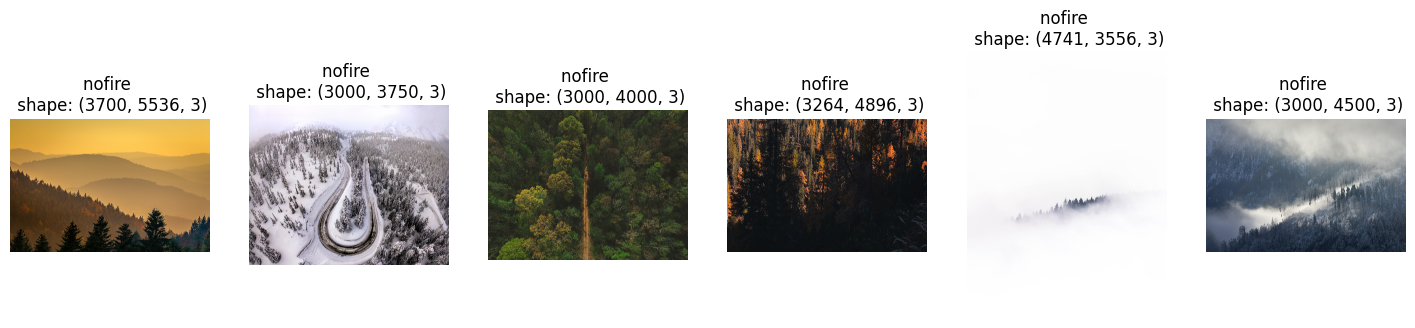

In [29]:
# Let's visualize the images in the dataset
plt.figure(figsize=(18, 12))
for i in range(6):
  class_path = os.path.join(train_dir, classes[0])
  img_name = os.listdir(class_path)[i]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(1, 6, i+1)
  plt.imshow(img)
  plt.title(f'{classes[0]} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

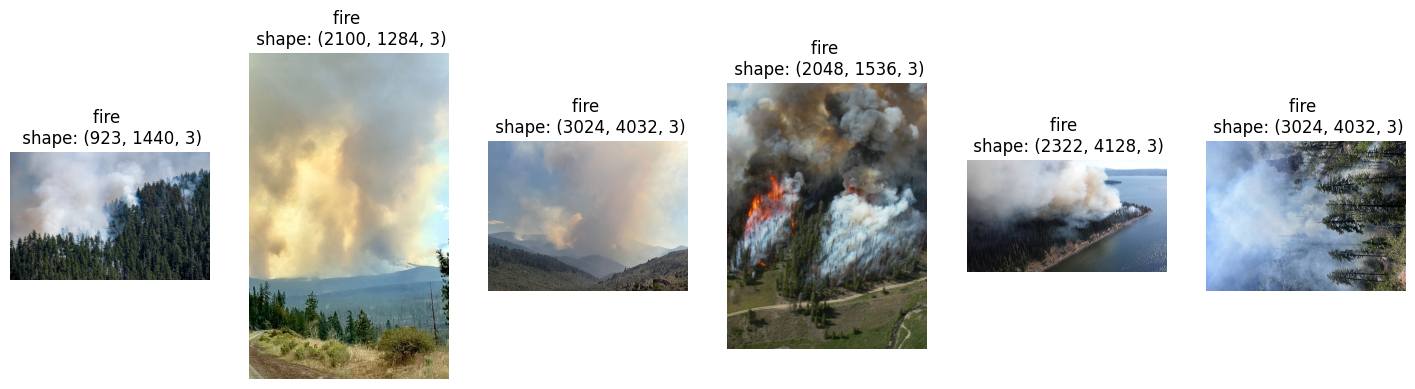

In [8]:
plt.figure(figsize=(18, 12))
for i in range(6):
  class_path = os.path.join(train_dir, classes[1])
  img_name = os.listdir(class_path)[i]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(1, 6, i+1)
  plt.imshow(img)
  plt.title(f'{classes[1]} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

In [58]:
# Preprocessing
# Image dimensions and batch size
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, width_shift_range=0.1,
                                   height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)


Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.
Class Names: ['fire', 'nofire']


In [64]:
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),
    Conv2D(32, (5, 5), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (5, 5), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=(2, 2)),

    # Remove Flatten() layer as it's incompatible with GlobalAveragePooling2D
    # Flatten(),

    GlobalAveragePooling2D(), # This layer now directly follows the last Conv2D output (4D)
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,689 (1.87 MB)

 Trainable params: 489,729 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=15, steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 482s 8s/step - accuracy: 0.7420 - loss: 0.7960 - val_accuracy: 0.4245 - val_loss: 1.0910
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8125 - loss: 0.7542 - val_accuracy: 0.4245 - val_loss: 1.1114
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 471s 8s/step - accuracy: 0.7379 - loss: 0.7440 - val_accuracy: 0.4010 - val_loss: 1.1374
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8125 - loss: 0.6111 - val_accuracy: 0.3906 - val_loss: 1.1811
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 485s 8s/step - accuracy: 0.7472 - loss: 0.6811 - val_accuracy: 0.4193 - val_loss: 1.2822
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8438 - loss: 0.5316 - val_accuracy: 0.4219 - val_loss: 1.3028
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 499s 9s/step - accuracy: 0.7485 - loss: 0.6452 - val_accuracy: 0.7135 - val_loss: 0.7056
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6562 - loss: 0.7443 - val_accuracy: 0.7240 - val_

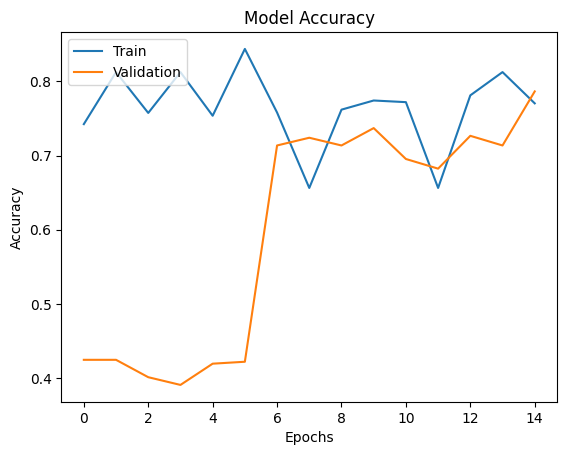

In [16]:
# Evaluate the model - plotting training and validation acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

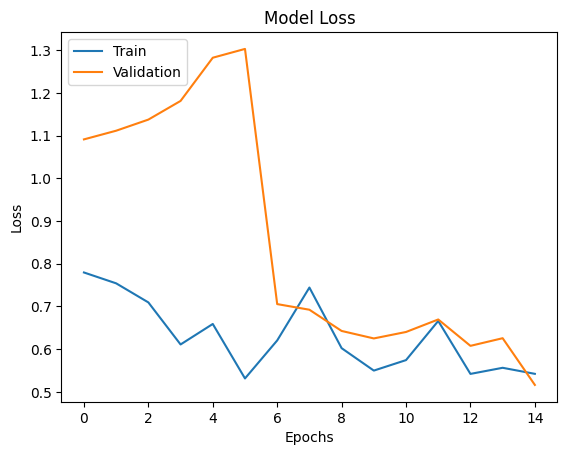

In [17]:
# Evaluate the model - plotting training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc:.4f}')

# Save Model
model.save('Forest_Fire_Detection_Enhanced.keras')

12/12 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.8257 - loss: 0.5040
Test Accuracy: 0.8021


In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model = load_model('Forest_Fire_Detection_Enhanced.keras')

# Predict on new image - create a function
def predict_fire(img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)
  if prediction[0] > 0.5:
    predicted_class = class_names[1]
  else:
    predicted_class = class_names[0]

  plt.imshow(img)
  plt.title(f'Predicted: {predicted_class}')
  plt.axis('off')
  plt.show()

In [36]:
def predict_from_url(image_url, model_path='Forest_Fire_Detection_Enhanced.keras'):
    # Load Model
    model = load_model(model_path)

    # Load Image from URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_resized = img.resize(img_size)

    # Preprocess
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[1] if prediction[0] > 0.5 else class_names[0]

    # Display Result
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

In [20]:
os.listdir('/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire')

['josh-sorenson-w_QAjcf1ipU-unsplash.jpg',
 'balazs-busznyak-AhMSy4GpU0w-unsplash.jpg',
 '52358616216_ec885ff145_o.jpg',
 'matthias-heil-T7lMR-syZAg-unsplash.jpg',
 'mark-boss-KG8N1Rqf02w-unsplash.jpg',
 'chris-barbalis-SIbpq4Lvzdk-unsplash.jpg',
 'brendan-beale-h3qe4EZd4_4-unsplash.jpg',
 'dan-rogers-G807nWEuFIo-unsplash.jpg',
 'hala-alghanim-yyE90v_E8dA-unsplash.jpg',
 'zetong-li-79sabz_JrXg-unsplash.jpg',
 'federico-bottos-JUFuI-kBtas-unsplash.jpg',
 'single-earth-FP5tOXT6aMs-unsplash.jpg',
 'sunnie-KJ_G43MHDf0-unsplash.jpg',
 '35581707273_fed23248e8_o.jpg',
 'martin-sanchez-ML6kHR--Uys-unsplash.jpg',
 'marek-piwnicki-DCGABYDIdT0-unsplash.jpg',
 'austin-schmid-zQ-y4Gj8194-unsplash.jpg',
 'rhema-kallianpur-t0GpJ2cdJuo-unsplash.jpg',
 'victor-rodriguez-e5g9otcYzkU-unsplash.jpg',
 'kristaps-ungurs-7aY6JOyFY8A-unsplash.jpg',
 '52452040025_916ddf3f9d_o.jpg',
 'daniil-silantev-VggwSJxYlAw-unsplash.jpg',
 'josh-withers-UN_W3z4D0pw-unsplash.jpg',
 'dave-hoefler-swH_IVJGLDA-unsplash.jpg',
 '

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


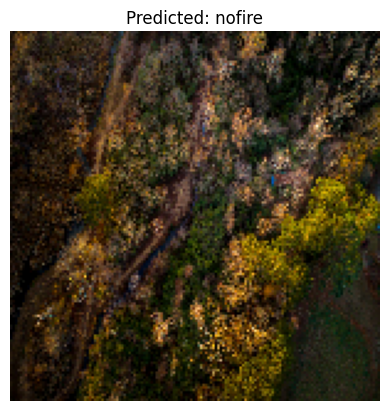

In [37]:
predict_fire('/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/nathan-anderson-d1gPSEN9dOE-unsplash.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


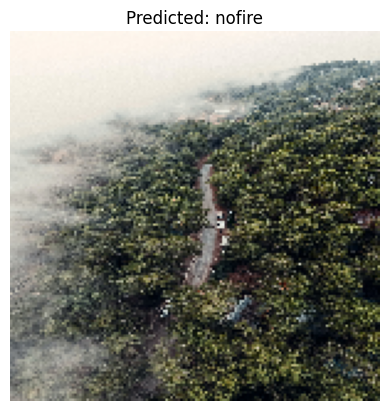

In [38]:
predict_fire('/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/bahadir-L2G0g3mSliU-unsplash.jpg')

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


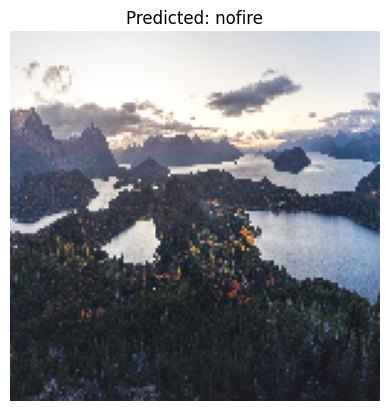

In [39]:
predict_fire('/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/andrew-svk-ob1NS03tWSE-unsplash.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


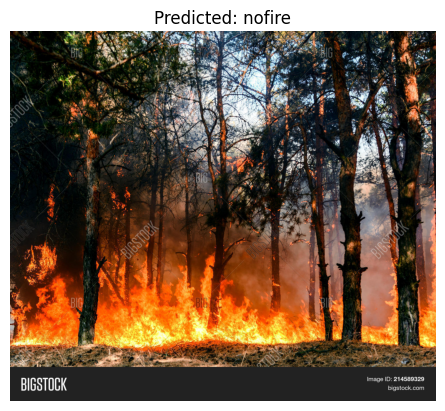

'nofire'

In [42]:
image_url = 'https://static1.bigstockphoto.com/4/1/2/large1500/214589329.jpg'
predict_from_url(image_url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


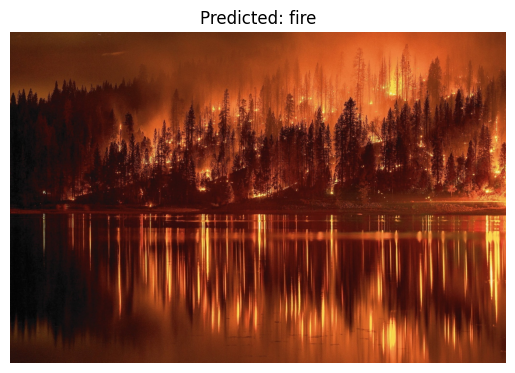

'fire'

In [41]:
image_url = 'https://www.wallpaperflare.com/static/974/997/71/fire-forest-lake-reflection-wallpaper.jpg'
predict_from_url(image_url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


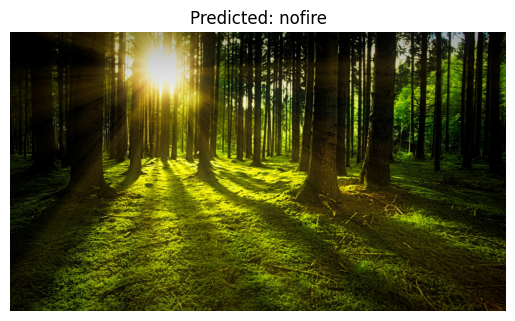

'nofire'

In [43]:
image_url = "https://images.pexels.com/photos/1125776/pexels-photo-1125776.jpeg?cs=srgb&dl=forest-grass-green-1125776.jpg&fm=jpg"
predict_from_url(image_url)

In [56]:
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model('Forest_Fire_Detection_Enhanced.keras')

# Class names (ensure correct order)
class_names = ['fire', 'nofire']

# Preprocess image to match model input
def preprocess_image(img, target_size=(150, 150)):
    img = img.convert('RGB')
    img = img.resize(target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Predict multiple images (URLs or Local Files)
def predict_fire_batch(image_paths):
    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(image_paths):
        try:
            # Load image from URL or local path
            if img_path.startswith('http'):
                response = requests.get(img_path)
                img = Image.open(BytesIO(response.content))
            else:
                img = Image.open(img_path)

            # Preprocess & Predict
            img_array = preprocess_image(img)
            prediction = model.predict(img_array, verbose=0)[0][0]
            predicted_label = class_names[1] if prediction > 0.5 else class_names[0]
            confidence = prediction if prediction > 0.5 else 1 - prediction

            # Print prediction
            print(f"[{i+1}] {predicted_label} ({confidence:.2%})")

            # Plot image with label
            plt.subplot(1, len(image_paths), i+1)
            plt.imshow(img)
            plt.title(f"{predicted_label}\n{confidence*100:.1f}%")
            plt.axis('off')

        except Exception as e:
            print(f"[{i+1}] Error: {e}")

    plt.tight_layout()
    plt.show()

[1] fire (58.11%)
[2] fire (50.66%)
[3] nofire (67.66%)
[4] nofire (75.38%)
[5] nofire (99.49%)
[6] nofire (77.09%)


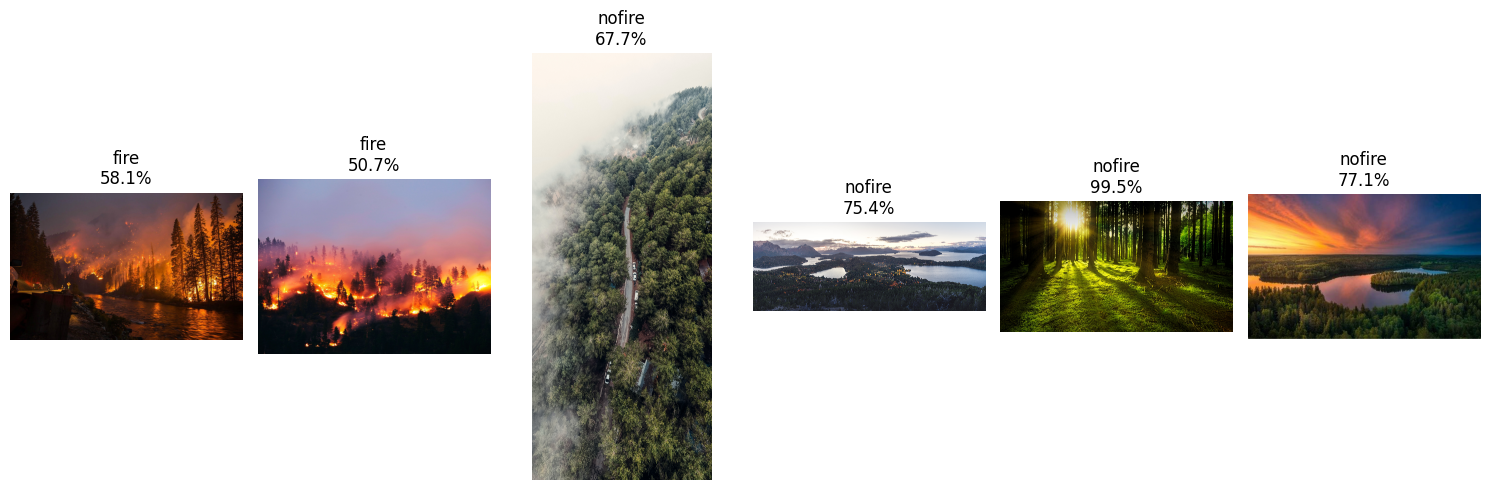

In [57]:
images = [
    "https://www.wallpaperflare.com/static/674/170/560/fire-forest-photo-wallpaper-preview.jpg",
    "https://i.pinimg.com/originals/37/77/57/3777573adb72146c9e7842c267bf3f3f.jpg",
    "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/bahadir-L2G0g3mSliU-unsplash.jpg",
    "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/andrew-svk-ob1NS03tWSE-unsplash.jpg",
    "https://images.pexels.com/photos/1125776/pexels-photo-1125776.jpeg?cs=srgb&dl=forest-grass-green-1125776.jpg&fm=jpg",
    "https://th.bing.com/th/id/OIP.ajK13B-4dQoWUxyF5xNe4AHaEo?cb=iwc2&w=1920&h=1200&rs=1&pid=ImgDetMain"
]
predict_fire_batch(images)


[1] nofire (50.13%)
[2] nofire (50.03%)
[3] nofire (50.01%)
[4] nofire (50.03%)
[5] nofire (50.04%)
[6] fire (50.00%)


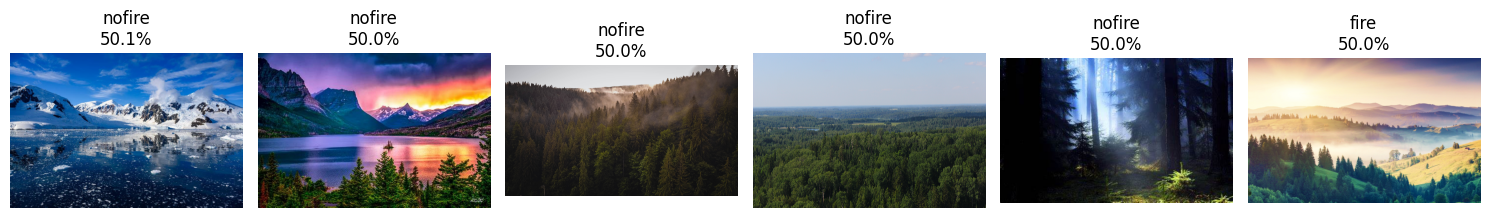

In [65]:
images = [
    "https://thumbs.dreamstime.com/b/beautiful-morning-sky-white-clouds-over-calm-south-antarctic-ocean-ice-flows-floating-snow-covered-mountains-171884316.jpg",
    "https://th.bing.com/th/id/OIP.ZsDN_p9zpn1jolgFk-utagHaE8?cb=iwc2&w=1600&h=1067&rs=1&pid=ImgDetMain",
    "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/cristian-vieriu-lDC7L1cQCeY-unsplash.jpg",
    "/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test/nofire/lasma-artmane-II0WWqBorw0-unsplash.jpg",
    "https://th.bing.com/th/id/OIP._Xu8HoypM4zPe_-sGwBdOAHaEo?cb=iwc2&rs=1&pid=ImgDetMain",
    "https://th.bing.com/th/id/R.61e41a02d066e7907a9c1cb2c055fca1?rik=g7%2fSEeg%2bz2jtXw&riu=http%3a%2f%2fwallup.net%2fwp-content%2fuploads%2f2015%2f12%2f81843-mist-trees-forest-sunrise-mountain-landscape.jpg&ehk=lL5s0DcRbpue4LJpKt5pnneYuoKF9sXFUSvHCHc7y4o%3d&risl=&pid=ImgRaw&r=0"
]
predict_fire_batch(images)